# 1st Assignment (A45432 - Adetbekov Yeldos)

## Initialization process
1) Importing all packages 

2) including image file from assets

2) Split colors to b, g, r channels separately

In [1]:
import cv2, os
import numpy as np
from matplotlib import pyplot as plt

path = 'assets/'
files = []
for f in os.listdir(path):
    files.append(cv2.imread(path + f))
imgs = np.array(files)
img = imgs[8]

b,g,r = cv2.split(img)

## Thresholding by optimal value
Here cv2.THRESH_BINARY make such like binary divider and cv2.THRESH_OTSU is adaptive algorithm which takes optimal thresholding value. It could separate foreground and background. Because we have static background, which color is pretty solid blue. We take thresholding by the "RED" channel.

In Otsu's method we exhaustively search for the threshold that minimizes the intra-class variance (the variance within the class), defined as a weighted sum of variances of the two classes:


$${\displaystyle \sigma _{w}^{2}(t)=\omega _{0}(t)\sigma _{0}^{2}(t)+\omega _{1}(t)\sigma _{1}^{2}(t)}$$

Weights ${\displaystyle \omega _{0}} $ and ${\displaystyle \omega _{1}} $ are the probabilities of the two classes separated by a threshold ${\displaystyle t}$ ,and ${\displaystyle \sigma}$ and ${\displaystyle \sigma _{1}^{2}}$ are variances of these two classes.
$${\displaystyle {\begin{aligned}\omega _{0}(t)&=\sum _{i=0}^{t-1}p(i)\\[4pt]\omega _{1}(t)&=\sum _{i=t}^{L-1}p(i)\end{aligned}}}$$

Otsu shows that minimizing the intra-class variance is the same as maximizing inter-class variance:

${\displaystyle {\begin{aligned}\sigma _{b}^{2}(t)&=\sigma ^{2}-\sigma _{w}^{2}(t)=\omega _{0}(\mu _{0}-\mu _{T})^{2}+\omega _{1}(\mu _{1}-\mu _{T})^{2}\\&=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}\end{aligned}}}$

which is expressed in terms of class probabilities ${\displaystyle \omega }$  and class means ${\displaystyle \mu }$.

while the class mean ${\displaystyle \mu _{0,1,T}(t)}$ is:

${\displaystyle {\begin{aligned}\mu _{0}(t)&=\sum _{i=0}^{t-1}i{\frac {p(i)}{\omega _{0}}}\\[4pt]\mu _{1}(t)&=\sum _{i=t}^{L-1}i{\frac {p(i)}{\omega _{1}}}\\\mu _{T}&=\sum _{i=0}^{L-1}ip(i)\end{aligned}}}$

The following relations can be easily verified:

${\displaystyle {\begin{aligned}\omega _{0}\mu _{0}+\omega _{1}\mu _{1}&=\mu _{T}\\\omega _{0}+\omega _{1}&=1\end{aligned}}}$

The class probabilities and class means can be computed iteratively. This idea yields an effective algorithm.

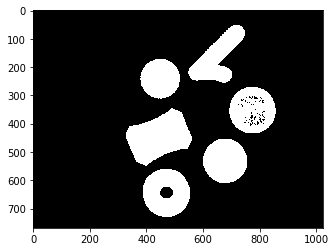

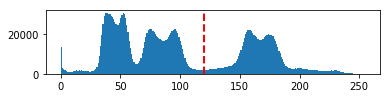

Treshold value: 120.0


In [ ]:
retval, threshold = cv2.threshold(r, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(threshold, cmap="gray")
plt.show()

plt.subplot(3,1,2), plt.hist(img.ravel(), 256)
plt.axvline(x=retval, color='r', linestyle='dashed', linewidth=2)
plt.show()

print("Treshold value:", retval)

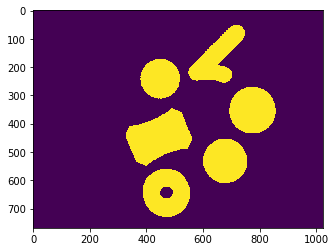

In [ ]:
def disk(r):
    y,x = np.ogrid[-r: r+1, -r: r+1]
    return 1*(x**2+y**2 <= r**2)

floodfill = threshold.copy()
h, w = threshold.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(floodfill, mask, (0,0), 255)
floodfill_inverted = cv2.bitwise_not(floodfill)
cleaned_holes = cv2.morphologyEx(floodfill, cv2.MORPH_CLOSE, disk(3))

out = cv2.bitwise_not(( threshold | floodfill_inverted ) + cleaned_holes)

plt.imshow(out)
plt.show()

## Smoothing surface
Because of the erossion noises and holes can be glued and this is effective way to make holes inside coin be equalized. Here for erossion we should set some parameters such as kernel and iterations:

1) Kernel is integer matrix, which will be cycled over the image pixel by pixel and make mathematical transformation. It is kind of masking pointer which will do operation over the image.

Let E be a Euclidean space or an integer grid, and A a binary image in E. The erosion of the binary image A by the structuring element B is defined by:


$${\displaystyle A\ominus B=\{z\in E|B_{z}\subseteq A\}}$$

,where Bz is the translation of B by the vector z, i.e., 

$${\displaystyle } B_{z}=\{b+z|b\in B\}, {\displaystyle \forall z\in E} \forall z\in E.$$


When the structuring element B has a center (e.g., a disk or a square), and this center is located on the origin of E, then the erosion of A by B can be understood as the locus of points reached by the center of B when B moves inside A. For example, the erosion of a square of side 10, centered at the origin, by a disc of radius 2, also centered at the origin, is a square of side 6 centered at the origin.

The erosion of A by B is also given by the expression: $${\displaystyle A\ominus B=\bigcap _{b\in B}A_{-b}}$$

2) Iterations is number of making this procedure.

In [ ]:
def disk(r):
    y,x = np.ogrid[-r: r+1, -r: r+1]
    return 1*(x**2+y**2 <= r**2)

In [ ]:
erosion = cv2.erode(out, disk(8), iterations = 2)
dilation = cv2.dilate(erosion, disk(4), iterations = 2)

# closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, disk(1))
# erosion = cv2.erode(closing, disk(10), iterations = 2)
# dilation = cv2.dilate(erosion, disk(4), iterations = 4)

plt.imshow(dilation, cmap="gray")
plt.show()

In [ ]:
im2, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

print(hierarchy)

In [ ]:
validCoins = []
cleaned_contours = []

for (i, c) in enumerate(contours):
    if(hierarchy[0][i][2] == -1 and hierarchy[0][i][3] == -1):
        cleaned_contours.append(c)       

for (i, c) in enumerate(cleaned_contours):
    m = cv2.moments(c)
    (x,y),radius = cv2.minEnclosingCircle(c)
    center = (int(x),int(y))
    radius = int(radius)
    perimeter = cv2.arcLength(c, True)
    circularity = (np.abs(perimeter)**2) / m['m00']

    if(circularity >= 13.5 and circularity <= 18):
        validCoins.append(c)
        cv2.circle(img, center, radius, (0, 255, 0), 3)
        cv2.putText(img, str(i), center, cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,0,0), 2)

plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
sortedCoins = []

for c in validCoins:
    s = cv2.contourArea(c)
    sortedCoins.append(s)
    
print(sorted(sortedCoins))

In [ ]:
def get_nominal(n):
    n = float(n)
    if n >= 1:
        if n.is_integer():
            return "{} euro".format(int(n))
        else:
            return "{} euros and {} cents".format(int(n), "{:0.2f}".format(np.round(n-int(n), decimals=2))[2:])
    else:
        return "{} cents".format("{:0.2f}".format(np.round(n-int(n), decimals=2))[2:])

In [ ]:
areas = [7000, 10000, 11000, 13000, 15000, 17000, 18000, 20000]
denominations = [0.01, 0.02, 0.10, 0.05, 0.20, 1, 0.50, 2]
total = 0

for c in validCoins:
    m = cv2.moments(c)
    s = cv2.contourArea(c)
    (x, y), radius = cv2.minEnclosingCircle(c)
    top = (int(x) - int(radius), int(y) - int(radius) - 7)
    
    for i, a in enumerate(areas):
        nextElement = areas[i+1] if areas[-1] != a else 22000
        thisElement = a
        currentDenominations = denominations[i]
        
        if s >= thisElement and s <= nextElement:
            total += currentDenominations
            cv2.putText(img, get_nominal(currentDenominations), top, cv2.FONT_HERSHEY_COMPLEX, 0.7, (255, 255, 255), 2)

cv2.putText(img, "Total: " + get_nominal(total), (50, 60), cv2.FONT_HERSHEY_COMPLEX, 1.2, (255, 255, 255), 2)
plt.imshow(img, cmap="gray", interpolation="none")
plt.show()
cv2.imshow("result", img)
cv2.waitKey(0)
cv2.destroyAllWindows()